In [8]:
import keras
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K, ops


from tensorflow import data as tf_data
from keras.layers import StringLookup
import numpy as np
import pandas as pd

import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv('/kaggle/input/income/train.csv')
data.rename(columns={'income_>50K': 'income'}, inplace=True)
data.drop(columns=['fnlwgt'], axis=1, inplace=True)
data

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,67,Private,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43952,52,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,1
43953,19,Private,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,0
43954,30,Private,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,58,United-States,0
43955,46,Private,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,35,United-States,0


In [3]:
# Define categorical and numerical features
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race',
                        'gender', 'native-country']
NUMERICAL_FEATURES = [col for col in data.columns if col not in CATEGORICAL_FEATURES + ['income']]
data[CATEGORICAL_FEATURES] = data[CATEGORICAL_FEATURES].astype(str)
# Fill missing values in categorical features
data[CATEGORICAL_FEATURES] = data[CATEGORICAL_FEATURES].fillna('UNKNOWN')

# Neural Decision Tree

In [4]:
class NeuralDecisionTreeWithEmbeddings(keras.Model):
    def __init__(self, depth, num_numeric_features, num_categorical_features, used_features_rate, num_classes, embedding_dim=3):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Create a mask for the randomly selected numeric features.
        num_used_numeric_features = int(num_numeric_features * used_features_rate)
        one_hot_numeric = np.eye(num_numeric_features)
        sampled_numeric_indices = np.random.choice(
            np.arange(num_numeric_features), num_used_numeric_features, replace=False
        )
        self.used_numeric_features_mask = ops.convert_to_tensor(
            one_hot_numeric[sampled_numeric_indices], dtype="float32"
        )

        # Create embedding layers for categorical features
        self.embedding_layers = []
        for _ in range(num_categorical_features):
            self.embedding_layers.append(layers.Embedding(input_dim=10, output_dim=embedding_dim))

        # Initialize the weights of the classes in leaves.
        self.pi = self.add_weight(
            initializer="random_normal",
            shape=[self.num_leaves, self.num_classes],
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, inputs):
        numeric_features, categorical_features = inputs

        batch_size = ops.shape(numeric_features)[0]

        # Apply the feature mask to the input numeric features.
        numeric_features = ops.matmul(
            numeric_features, ops.transpose(self.used_numeric_features_mask)
        )  # [batch_size, num_used_numeric_features]

        # Apply embeddings to categorical features
        embedded_categorical_features = []
        for i, layer in enumerate(self.embedding_layers):
            embedded_categorical_features.append(layer(categorical_features[:, i]))

        # Concatenate all embedded categorical features
        embedded_categorical_features = layers.concatenate(embedded_categorical_features)

        # Concatenate numeric and categorical features
        features = layers.concatenate([numeric_features, embedded_categorical_features])

        # Compute the routing probabilities.
        decisions = ops.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = ops.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = ops.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = ops.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = ops.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = ops.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs


In [5]:
# Encode categorical features
label_encoders = {}
for feature in CATEGORICAL_FEATURES:
    label_encoders[feature] = LabelEncoder()
    data[feature] = label_encoders[feature].fit_transform(data[feature])

# Normalize numerical features
scaler = StandardScaler()
data[NUMERICAL_FEATURES] = scaler.fit_transform(data[NUMERICAL_FEATURES])

# Split data into features and target
X = data.drop(columns=['income'])
y = data['income']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare categorical features
X_train_categorical = X_train[CATEGORICAL_FEATURES].values
X_test_categorical = X_test[CATEGORICAL_FEATURES].values

# Prepare numerical features
X_train_numeric = X_train[NUMERICAL_FEATURES].values
X_test_numeric = X_test[NUMERICAL_FEATURES].values

# Convert target labels to one-hot encoding
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# Define model parameters
depth = 5
num_numeric_features = X_train_numeric.shape[1]
num_categorical_features = X_train_categorical.shape[1]
used_features_rate = 0.5
num_classes = y_train.shape[1]
embedding_dim = 3

# Instantiate the model
model = NeuralDecisionTreeWithEmbeddings(depth=depth,
                                         num_numeric_features=num_numeric_features,
                                         num_categorical_features=num_categorical_features,
                                         used_features_rate=used_features_rate,
                                         num_classes=num_classes,
                                         embedding_dim=embedding_dim)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/25
880/880 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8319 - loss: 0.3603 - val_accuracy: 0.8308 - val_loss: 0.3653
Epoch 2/25
880/880 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8340 - loss: 0.3561 - val_accuracy: 0.8309 - val_loss: 0.3656
Epoch 3/25
880/880 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8362 - loss: 0.3536 - val_accuracy: 0.8315 - val_loss: 0.3654
Epoch 4/25
880/880 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8354 - loss: 0.3528 - val_accuracy: 0.8307 - val_loss: 0.3640
Epoch 5/25
880/880 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8334 - loss: 0.3566 - val_accuracy: 0.8311 - val_loss: 0.3656
Epoch 6/25
880/880 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8388 - loss: 0.3506 - val_accuracy: 0.8299 - val_loss: 0.3638
Epoch 7/25
880/880 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8358 - loss: 0.3532 - val_accuracy: 0.8299 - val_loss: 0.3639
Epoch 8/25
880/880 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8349 - loss: 0.3570 - val_accuracy: 0.

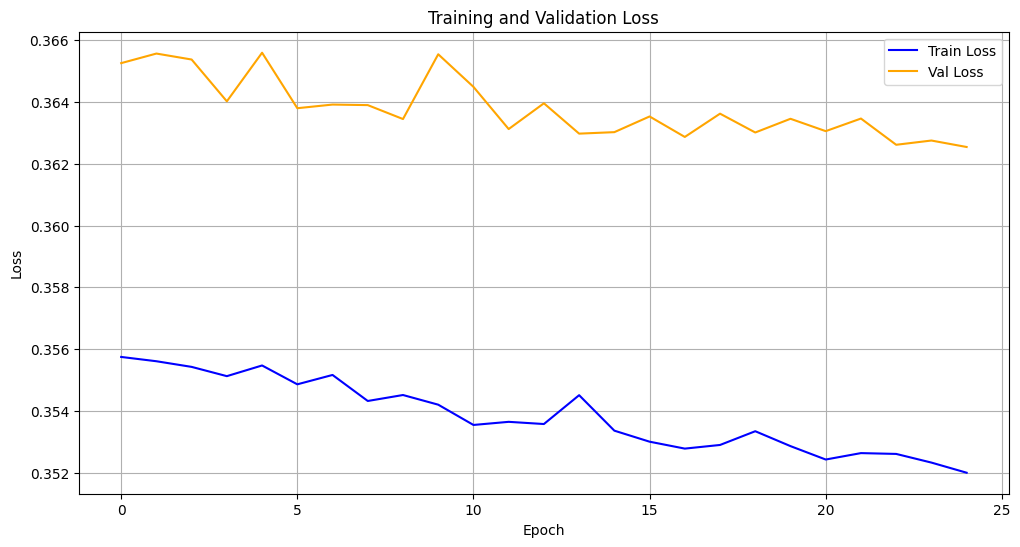

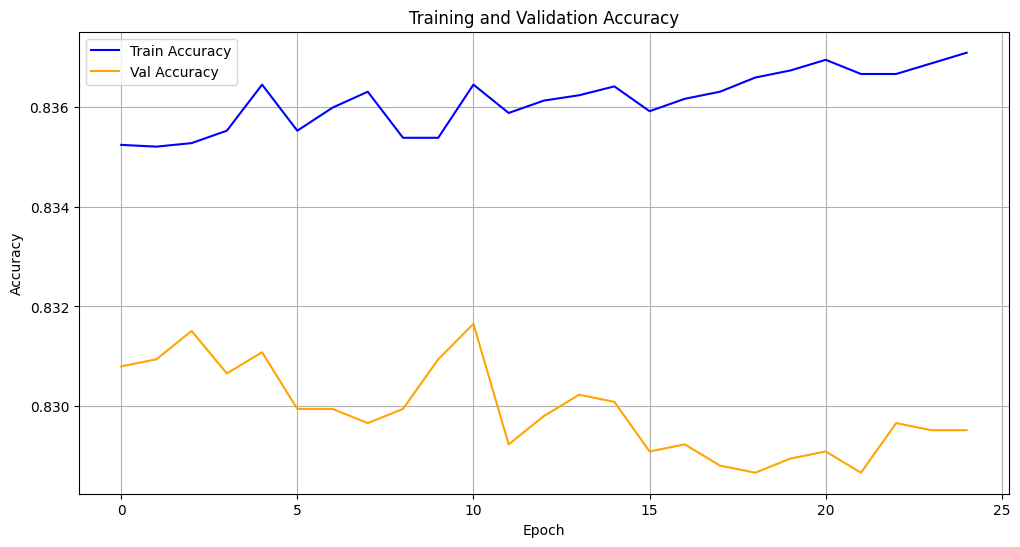

In [9]:
# Train the model
history = model.fit([X_train_numeric, X_train_categorical], y_train, epochs=25, batch_size=32, validation_split=0.2)
print("Model training finished.")

print("Evaluating model performance...")
loss, accuracy = model.evaluate([X_test_numeric, X_test_categorical], y_test)
print("Val Loss:", loss)
print("Val Accuracy:", accuracy)
# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Val Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.plot(val_acc, label='Val Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test_numeric, X_test_categorical], y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8288 - loss: 0.3581
Test Loss: 0.358325332403183
Test Accuracy: 0.8333712220191956


# Inference

In [11]:
new_data = pd.read_csv('/kaggle/input/income/test.csv')
new_data[CATEGORICAL_FEATURES] = new_data[CATEGORICAL_FEATURES].fillna('UNKNOWN')

In [12]:
# Assuming new_data is the DataFrame containing new data without the target column

# Preprocess categorical features
new_categorical_features_encoded = []
for col in CATEGORICAL_FEATURES:
    if col in label_encoders:
        new_categorical_features_encoded.append(label_encoders[col].transform(new_data[col].astype(str)))
    else:
        # Handle unseen categories
        unknown_category_index = label_encoders[col].classes_.shape[0]  # Assume 'UNKNOWN' category is the last one
        unknown_category_array = np.full_like(new_data[col], unknown_category_index)
        new_categorical_features_encoded.append(unknown_category_array)
new_categorical_features_encoded = np.array(new_categorical_features_encoded).T

# Fill missing values in numerical features and normalize
new_data[NUMERICAL_FEATURES] = scaler.transform(new_data[NUMERICAL_FEATURES])

# Prepare categorical features
new_categorical_features = new_categorical_features_encoded

# Prepare numerical features
new_numeric_features = new_data[NUMERICAL_FEATURES].values

# Make predictions
predictions = model.predict([new_numeric_features, new_categorical_features])


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [13]:
predictions

array([[0.7566063 , 0.24339375],
       [0.5263364 , 0.47366366],
       [0.72422254, 0.27577755],
       ...,
       [0.9956334 , 0.00436651],
       [0.5239712 , 0.4760288 ],
       [0.2205396 , 0.7794604 ]], dtype=float32)

# Neural Decision Forest

In [14]:
class NeuralDecisionForestWithEmbeddings(keras.Model):
    def __init__(self, num_trees, depth, num_numeric_features, num_categorical_features, used_features_rate, num_classes, embedding_dim=3):
        super().__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTreeWithEmbeddings instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTreeWithEmbeddings(depth, num_numeric_features, num_categorical_features, used_features_rate, num_classes, embedding_dim)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = ops.shape(inputs[0])[0]
        outputs = ops.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs


In [15]:
# Define model parameters
num_trees = 10  # Number of trees in the forest
depth = 5
num_numeric_features = X_train_numeric.shape[1]
num_categorical_features = X_train_categorical.shape[1]
used_features_rate = 0.5
num_classes = y_train.shape[1]
embedding_dim = 3

# Instantiate the model
model2 = NeuralDecisionForestWithEmbeddings(num_trees=num_trees,
                                            depth=depth,
                                            num_numeric_features=num_numeric_features,
                                            num_categorical_features=num_categorical_features,
                                            used_features_rate=used_features_rate,
                                            num_classes=num_classes,
                                            embedding_dim=embedding_dim)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - accuracy: 0.7660 - loss: 0.5802 - val_accuracy: 0.8257 - val_loss: 0.4130
Epoch 2/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8365 - loss: 0.3898 - val_accuracy: 0.8308 - val_loss: 0.3693
Epoch 3/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8409 - loss: 0.3533 - val_accuracy: 0.8393 - val_loss: 0.3516
Epoch 4/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8439 - loss: 0.3367 - val_accuracy: 0.8402 - val_loss: 0.3424
Epoch 5/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8471 - loss: 0.3322 - val_accuracy: 0.8426 - val_loss: 0.3363
Epoch 6/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8483 - loss: 0.3327 - val_accuracy: 0.8435 - val_loss: 0.3328
Epoch 7/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8496 - loss: 0.3250 - val_accuracy: 0.8446 - val_loss: 0.3298
Epoch 8/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8486 - loss: 0.3223 - val

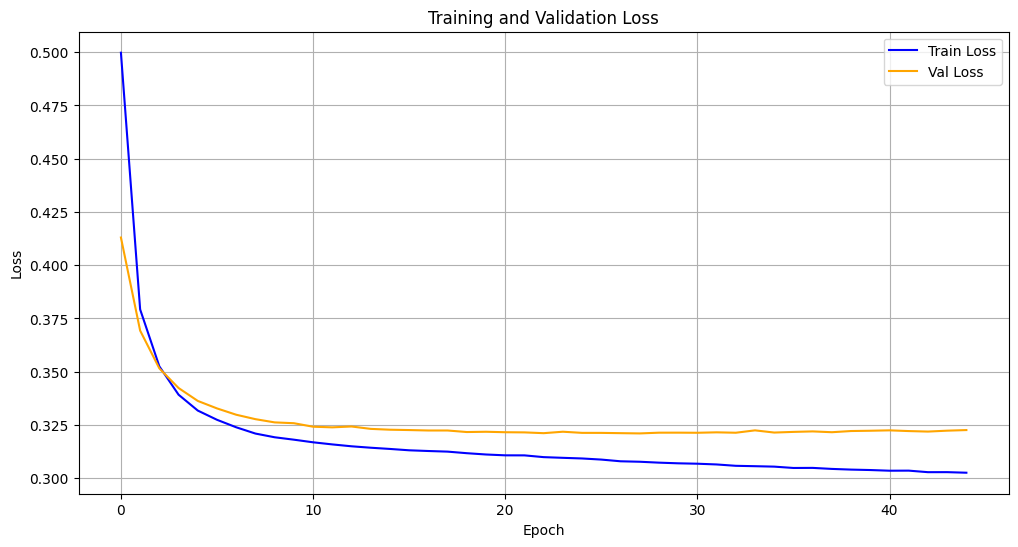

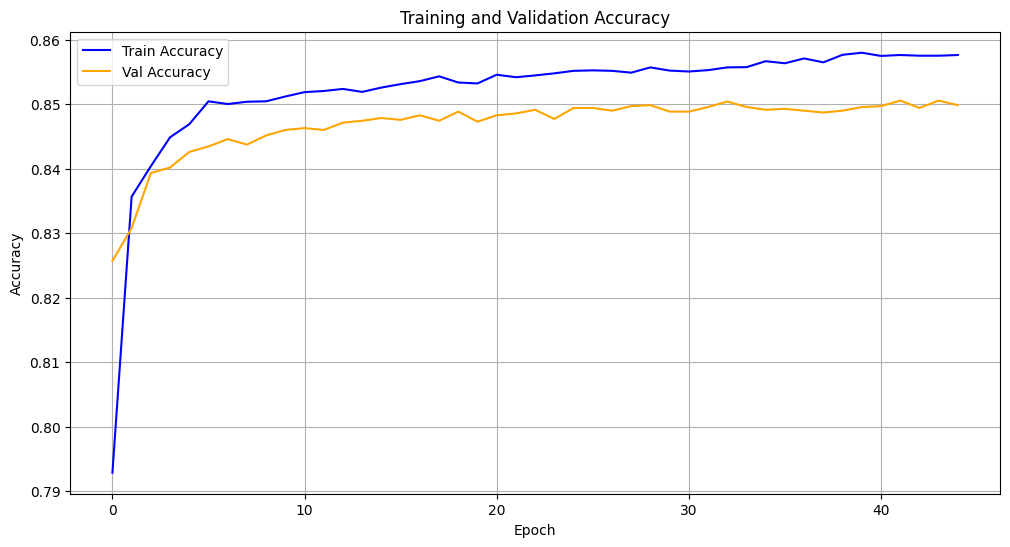

In [16]:
# Train the model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model2.fit([X_train_numeric, X_train_categorical],
                     y_train, epochs=45, batch_size=32, validation_split=0.2,
                     callbacks=[early_stopping])
print("Model training finished.")

print("Evaluating model performance...")
loss, accuracy = model2.evaluate([X_test_numeric, X_test_categorical], y_test)
print("Val Loss:", loss)
print("Val Accuracy:", accuracy)

# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Val Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.plot(val_acc, label='Val Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test_numeric, X_test_categorical], y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8288 - loss: 0.3581
Test Loss: 0.358325332403183
Test Accuracy: 0.8333712220191956


# Inference

In [18]:
predictions = model2.predict([new_numeric_features, new_categorical_features])

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step


In [19]:
predictions

array([[7.7304983e-01, 2.2695020e-01],
       [6.4240438e-01, 3.5759565e-01],
       [6.3591027e-01, 3.6408973e-01],
       ...,
       [9.9956816e-01, 4.3193894e-04],
       [5.7495862e-01, 4.2504129e-01],
       [2.2270904e-01, 7.7729100e-01]], dtype=float32)